### Cut-off Vr.2 (Entropy)

#### using entropy measure + percentage difference

In [1]:
# Import Modules
import pandas as pd
import numpy as np
from nltk import FreqDist
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [2]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [3]:
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [4]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]

df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

In [5]:
shareTrend = {'tagName' : df_share['index'], 'preGPT': df_share.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_share.iloc[:, 731:].mean(axis = 1, skipna=True)}
shareTrend = pd.DataFrame(shareTrend)

In [6]:
# Convert nan to 0
shareTrend.fillna(0, inplace = True)
shareTrend['diff'] = shareTrend['postGPT'] - shareTrend['preGPT']

In [7]:
shareTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,diff
242,nextDOTjs,0.287568,0.452411,0.164843
442,springboot,0.425927,0.546275,0.120348
168,seleniumwebdriver,0.097958,0.218038,0.120081
29,angular,0.495756,0.557043,0.061287
51952,boomerangapp,0.000000,0.053050,0.053050
...,...,...,...,...
149,dataframe,0.563057,0.401511,-0.161546
28,arrays,0.578478,0.361360,-0.217118
72,pandas,0.929865,0.647534,-0.282331
5,javascript,3.548633,3.055816,-0.492817


#### 1. Percentile Cut-off using Entropy

In [8]:
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result

In [9]:
def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

In [10]:
percentList = [0, 5, 10, 15, 20, 25, 30, 35, 50, 55]
for i in range(len(percentList)):
    print(np.percentile(shareTrend['diff'], percentList[i]))

-0.8176378288412902
-0.005997361161089121
-0.0003983535476307279
0.0
0.0
0.0
0.0008472433995637697
0.00144021696956889
0.0026274902885756405
0.003003654315211727


In [11]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25, 30]

result_df = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    lower_bound = np.percentile(shareTrend['diff'], percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_df = pd.concat([result_df, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384575/3744754994.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, result_model], ignore_index = True)


In [12]:
result_df

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,3.210877e-04
1,5,0.044318,0.010316,1.740059e-05
2,10,0.066676,0.011839,1.784572e-08
3,15,0.071761,0.012170,3.714292e-09
4,20,0.071761,0.012170,3.714292e-09
5,25,0.071761,0.012170,3.714292e-09
6,30,0.090574,0.012913,2.314349e-12


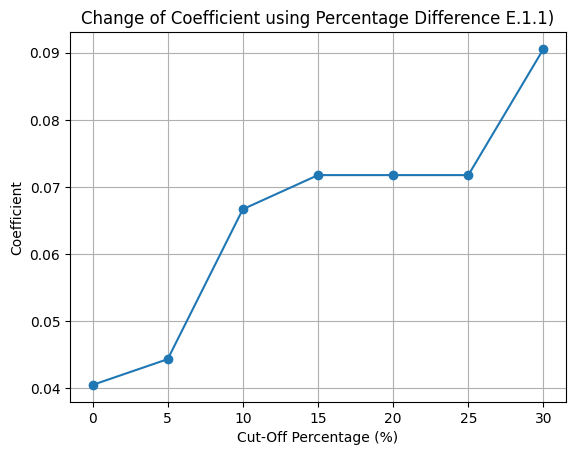

In [13]:
# Visualization
fig, ax = plt.subplots()

ax.plot(result_df['cut_off_percentage'], result_df['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Percentage Difference E.1.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')
# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

#### 2. Bottom-K Cut off using entropy

In [14]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #, 2618]
result_ls_bottomK = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('diff', ascending = True)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_ls_bottomK = pd.concat([result_ls_bottomK, result_model_bottomK], ignore_index = True)
    #result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384575/2736989867.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_ls_bottomK = pd.concat([result_ls_bottomK, result_model_bottomK], ignore_index = True)


In [15]:
result_ls_bottomK

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,0.000321
1,2,0.024226,0.009451,0.010366
2,4,0.023124,0.009475,0.014662
3,6,0.022604,0.009570,0.018179
4,8,0.022698,0.009570,0.017700
5,10,0.022490,0.009384,0.016552
6,12,0.022573,0.009373,0.016028
7,14,0.021639,0.009193,0.018573
8,16,0.021830,0.009122,0.016707
9,18,0.021747,0.009182,0.017865


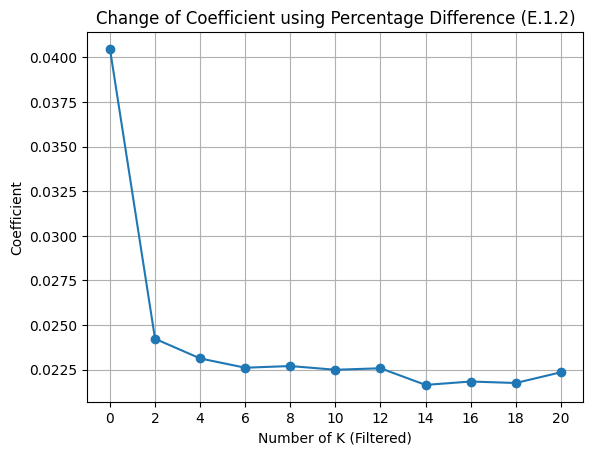

In [16]:
# Plotting the line graph
# Create a figure and an axes
fig, ax = plt.subplots()

ax.plot(result_ls_bottomK['cut_off_percentage'].astype('str'), result_ls_bottomK['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Percentage Difference (E.1.2)')
ax.set_xlabel('Number of K (Filtered)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

#### Share Volumne approach

#### 1) using quantile 

In [17]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25, 30]

result_vr3 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    upper_bound = np.percentile(shareTrend['preGPT'], 100 - percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = shareTrend[(shareTrend['preGPT'] <= upper_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384575/2849127393.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr3 = pd.concat([result_vr3, result_model], ignore_index = True)


In [18]:
result_vr3

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,3.210877e-04
1,5,0.088869,0.016681,9.946116e-08
2,10,0.125227,0.021912,1.097857e-08
3,15,0.175945,0.029847,3.748534e-09
4,20,0.257732,0.040618,2.220542e-10
5,25,0.392748,0.057841,1.120519e-11
6,30,0.657848,0.092521,1.158120e-12


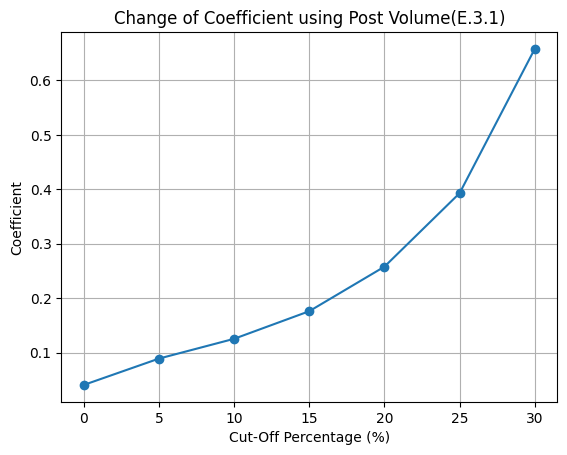

In [19]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_vr3['cut_off_percentage'], result_vr3['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume(E.3.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()

#### 2. using bottom-k 

In [20]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #, 2618]
result_vr4 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('preGPT', ascending = True)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)
    #result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_384575/2622857272.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr4 = pd.concat([result_vr4, result_model_bottomK], ignore_index = True)


In [21]:
result_vr4

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,0.000321
1,2,0.040472,0.011251,0.000322
2,4,0.040470,0.011251,0.000322
3,6,0.040459,0.011252,0.000323
4,8,0.040459,0.011252,0.000323
5,10,0.040456,0.011251,0.000324
6,12,0.040456,0.011252,0.000324
7,14,0.040454,0.011251,0.000324
8,16,0.040447,0.011252,0.000325
9,18,0.040441,0.011252,0.000326


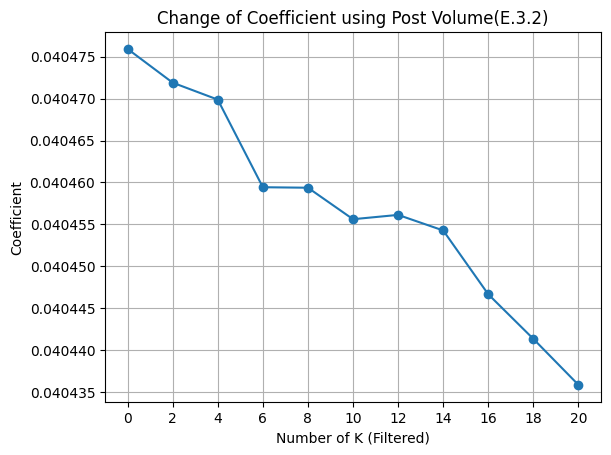

In [22]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_vr4['cut_off_percentage'].astype('str'), result_vr4['coef'], marker='o')  # Added a marker for each data point

# Adding title and labels
ax.set_title('Change of Coefficient using Post Volume(E.3.2)')
ax.set_xlabel('Number of K (Filtered)')
ax.set_ylabel('Coefficient')

# Optionally add grid
ax.grid(True)

# Display the plot
plt.show()